## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (204 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
dir='/content/drive/MyDrive/slides'

In [5]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [6]:
#defining some helper functions to get the tissue density in a slide and to apply a monotone mask on an image

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  

def apply_mask(im, mask,  color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

Reading 4 train slides

In [7]:
slide_url=[]
mask_url=[]
slide_path=[]
tumor_mask_path=[]

In [8]:
# slide_path.extend(['tumor_110.tif','tumor_075.tif','tumor_031.tif','tumor_016.tif'])
# tumor_mask_path.extend(['tumor_110_mask.tif','tumor_075_mask.tif','tumor_031_mask.tif','tumor_016_mask.tif'])

slide_url.extend([dir+'/tumor_110.tif',dir+'/tumor_075.tif',dir+'/tumor_031.tif',dir+'/tumor_016.tif'])
mask_url.extend([dir+'/tumor_110_mask.tif',dir+'/tumor_075_mask.tif',dir+'/tumor_031_mask.tif',dir+'/tumor_016_mask.tif'])



In [9]:
# for i in slide_url:
#   !curl -O $i

In [10]:
# for i in mask_url:
#   !curl -O $i

In [11]:
def path_to_slide(path):
  return open_slide(path)

trainset_tumor_slide = list(map(lambda path: path_to_slide(path), slide_url))
trainset_mask_slide = list(map(lambda path: path_to_slide(path), mask_url))
trainset_name = list(map(lambda x: x.split('/')[-1], slide_path))

In [12]:
trainset_tumor_slide

[OpenSlide('/content/drive/MyDrive/slides/tumor_110.tif'),
 OpenSlide('/content/drive/MyDrive/slides/tumor_075.tif'),
 OpenSlide('/content/drive/MyDrive/slides/tumor_031.tif'),
 OpenSlide('/content/drive/MyDrive/slides/tumor_016.tif')]

In [13]:
trainset_name

['tumor_110.tif', 'tumor_075.tif', 'tumor_031.tif', 'tumor_016.tif']

In [14]:
slide_url_test=[]
mask_url_test=[]
slide_path_test=[]
tumor_mask_path_test=[]

In [15]:
# slide_path_test.extend(['tumor_091.tif','tumor_096.tif','tumor_078.tif'])
# tumor_mask_path_test.extend(['tumor_091_mask.tif','tumor_096_mask.tif','tumor_078_mask.tif'])

slide_url_test.extend([dir+'/tumor_091.tif',dir+'/tumor_096.tif',dir+'/tumor_078.tif'])
mask_url_test.extend([dir+'/tumor_091_mask.tif',dir+'/tumor_096_mask.tif',dir+'/tumor_078_mask.tif'])


In [16]:
# for i in slide_url_test:
#   !curl -O $i

In [17]:
# for i in mask_url_test:
#   !curl -O $i

Reading 3 test slides

In [18]:
testset_tumor_slide = list(map(lambda path: path_to_slide(path), slide_url_test))
testset_mask_slide = list(map(lambda path: path_to_slide(path), mask_url_test))

In [19]:
testset_tumor_slide

[OpenSlide('/content/drive/MyDrive/slides/tumor_091.tif'),
 OpenSlide('/content/drive/MyDrive/slides/tumor_096.tif'),
 OpenSlide('/content/drive/MyDrive/slides/tumor_078.tif')]

In [20]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate

In [21]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks 

2.4.0


In [22]:
def create_model(patch_size):
  """
  function: create the model at given patch_size
  
  """

  vgg_zoom1 = tf.keras.applications.VGG16(weights='imagenet',
                                    include_top=False,
                                    input_shape=(patch_size, patch_size, 3))

  vgg_zoom2 = tf.keras.applications.VGG16(weights='imagenet',
                                      include_top=False,
                                      input_shape=(patch_size, patch_size, 3))

  # freeze the VGG model to increase training speed
  vgg_zoom1.trainable = False
  vgg_zoom2.trainable = False

  # create the base model
  model_zoom1 = Sequential()
  model_zoom1.add(vgg_zoom1)
  model_zoom1.add(GlobalAveragePooling2D())
  model_zoom1.add(Dense(128,activation='relu'))

  model_zoom2 = Sequential()
  model_zoom2.add(vgg_zoom2)
  model_zoom2.add(GlobalAveragePooling2D())
  model_zoom2.add(Dense(128,activation='relu'))

  input_zoom1 = Input(shape=(patch_size, patch_size, 3))
  input_zoom2 = Input(shape=(patch_size, patch_size, 3))

  encoded_zoom1 = model_zoom1(input_zoom1)
  encoded_zoom2 = model_zoom2(input_zoom2)

  merged = concatenate([encoded_zoom1, encoded_zoom2])
  dense1 = Dense(128, activation='relu')(merged)
  drop_layer = Dropout(0.5)(dense1)
  dense2 = Dense(64, activation='relu')(drop_layer)

  output = Dense(1, activation='sigmoid')(dense2)
  model = Model(inputs=[input_zoom1, input_zoom2], outputs=output)

  return model

In [23]:
model=create_model(299)

58892288/58889256 [==============================] - 1s 0us/step


In [24]:

def generate_patches(slide, mask, zoom_level1, zoom_level2, dim, not_filtered=False):
    factor1 = int(slide.level_downsamples[zoom_level1])
    factor2 = int(slide.level_downsamples[zoom_level2])
    # Extract Max width and height
    width_1 = slide.level_dimensions[zoom_level1][0]
    height_1 = slide.level_dimensions[zoom_level1][1]
    print("Width: %s, Height: %s" %(width_1,height_1))
    
    # Calculate How many samples do we need on each direction 
    w_samples = width_1//dim
    h_samples = height_1//dim

    patches_1 = [] 
    patches_masks_1 = []
    labels = []
    patches_2 = [] 
    patches_masks_2 = []
    xs = []
    ys = []
    # Get Higher Level and patches indexes.
    for j in range(h_samples):
        for i in range(w_samples):
            x1 = i*dim*factor1
            y1 = j*dim*factor1
            if(not_filtered or (((x1+(dim*factor1)) <= slide.level_dimensions[0][0]) and ((y1+(dim*factor1)) < slide.level_dimensions[0][1]))):
                mask_img1 = read_slide(mask, x = x1, y = y1, level=zoom_level1, width=dim, height=dim)[:,:,0]
                slide_img1 = read_slide(slide, x = x1, y = y1, level=zoom_level1, width=dim, height=dim)
                tissue_pixels = list(find_tissue_pixels(slide_img1))
                percent_tissue = len(tissue_pixels) / float(slide_img1.shape[0] * slide_img1.shape[0]) * 100 
                if percent_tissue > 10 or not_filtered: #Only keep tissue more than 10%
                    xs.append(x1)
                    ys.append(y1)
                    patches_masks_1.append(mask_img1)
                    patches_1.append(slide_img1)
    # Get Labels and lower zoom
    for i in range(len(patches_1)):
      factor = ((dim-dim//(factor1//factor2))//2)*factor1
      mask_img2 = read_slide(mask, x = (xs[i]+factor), y = (ys[i]+factor), level=zoom_level2, width=dim, height=dim)[:,:,0]
      slide_img2 = read_slide(slide, x = (xs[i]+factor), y = (ys[i]+factor), level=zoom_level2, width=dim, height=dim)
      patches_masks_2.append(mask_img2)
      patches_2.append(slide_img2)
      # Read the label from level 7 128*128
      label_mask = read_slide(mask, x = (xs[i]+((dim-128)//2)*factor1), y = (ys[i]+((dim-128)//2)*factor1), level=zoom_level2, width=128, height=128)[:,:,0]
      if np.count_nonzero(label_mask) > 0:
        labels.append(1)
      else:
        labels.append(0)
   
    return patches_1, patches_masks_1, patches_2, patches_masks_2, labels

In [25]:
patches_1=[]
patches_2=[]
patches_masks_1=[]
patches_masks_2=[]
labels=[]

Reading samples of patches1,patches2 at zoom level 2 and 3 and each patch has dimension 299*299

In [27]:
for i in range(len(trainset_tumor_slide)):
  patches_1_temp, patches_masks_1_temp, patches_2_temp, patches_masks_2_temp, labels_temp= generate_patches(trainset_tumor_slide[i], trainset_mask_slide[i], 3, 2, 299)
  patches_1.extend(patches_1_temp)
  patches_2.extend(patches_2_temp)
  patches_masks_1.extend(patches_masks_1_temp)
  patches_masks_2.extend(patches_masks_2_temp)
  labels.extend(labels_temp)

Width: 11776, Height: 8960
Width: 11264, Height: 9856
Width: 12224, Height: 27648
Width: 12224, Height: 27648


converting to np array

In [28]:
patches_1=np.array(patches_1)
patches_2=np.array(patches_2)
labels=np.array(labels)

Checking number of patches are same at both the zoom levels as well as in labels

In [30]:
patches_1.shape

(1444, 299, 299, 3)

In [29]:
patches_2.shape

(1444, 299, 299, 3)

In [31]:
labels.shape

(1444,)

In [32]:
batch_size = 32
#performing data augmentation
train_gen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale=1./255,
                               width_shift_range=(-8, 8),
                               height_shift_range=(-8, 8),
                               rotation_range = 90) 


val_gen = ImageDataGenerator(rescale=1./255)

#creating train and val flow for model training 

def train_gen_for_two(X1, X2, Y, random_seed = 123):
    genX1 = train_gen.flow(X1,Y, seed = random_seed, batch_size=batch_size)
    genX2 = train_gen.flow(X2, seed = random_seed, batch_size=batch_size)
    while True:
      X1i = genX1.next()
      X2i = genX2.next()
      yield [X1i[0], X2i], X1i[1]


def val_gen_for_two(X1, X2, Y, random_seed = 123):
    genX1 = val_gen.flow(X1,Y, seed = random_seed, batch_size=batch_size)
    genX2 = val_gen.flow(X2, seed = random_seed, batch_size=batch_size)
    while True:
      X1i = genX1.next()
      X2i = genX2.next()
      yield [X1i[0], X2i], X1i[1]

Creating train and val data

In [33]:
len_train=int(0.8*len(patches_1))

In [34]:
patches_1_train=patches_1[:len_train]
patches_1_val=patches_1[len_train:]

In [35]:
len(patches_1_train)+len(patches_1_val)==len(patches_1)

True

In [36]:
len_train_2=int(0.8*len(patches_2))
patches_2_train=patches_2[:len_train_2]
patches_2_val=patches_2[len_train_2:]

In [37]:
len_labels=int(0.8*len(labels))
labels_train=labels[:len_labels]
labels_val=labels[len_labels:]

In [38]:
train_flow = train_gen_for_two(patches_1_train, patches_2_train, labels_train)
val_flow = val_gen_for_two(patches_1_val, patches_2_val, labels_val)


Check the shape of the inputs and outputs in the train and val flow 

In [39]:

input_1 = 0
output_1 = 0
z = 0
one = 0
for x1,y in train_flow:
  print(x1[0].shape)
  print(x1[1].shape)
  break
  

(32, 299, 299, 3)
(32, 299, 299, 3)


In [40]:
input_1 = 0
output_1 = 0
z = 0
one = 0
for x1,y in val_flow:
  print(x1[0].shape)
  print(x1[1].shape)
  break

(32, 299, 299, 3)
(32, 299, 299, 3)


Calculating class labels to handle class imbalance

In [41]:
zero_counter=len(labels_train)-sum(labels_train)
one_counter=sum(labels_train)

In [42]:
total = one_counter + zero_counter

weight_for_0 = (1 / zero_counter)*(total)/2.0 
weight_for_1 = (1 / one_counter)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.6438127090301003, 1: 2.238372093023256}


We have used **AUC** as the main metric for evaluation and comparison of different models

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer ='adam',
              metrics=tf.keras.metrics.AUC(name='auc'))

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)


In [46]:
history = model.fit(
  train_flow,
  validation_data=val_flow,
  steps_per_epoch = len(patches_1_train) // batch_size,
  validation_steps=len(patches_1_val)// batch_size,
  epochs=10,class_weight=class_weight,callbacks=[callback])

Epoch 1/10
36/36 [==============================] - 71s 2s/step - loss: 0.5662 - auc: 0.7896 - val_loss: 0.4743 - val_auc: 0.9242
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 0.3309 - auc: 0.9363 - val_loss: 0.7043 - val_auc: 0.9274


In [ ]:
model.save("/content/best_model.h5")

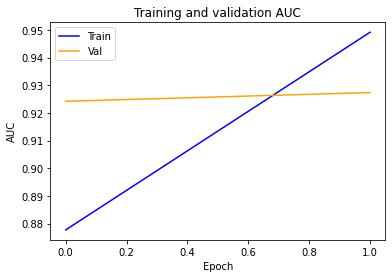

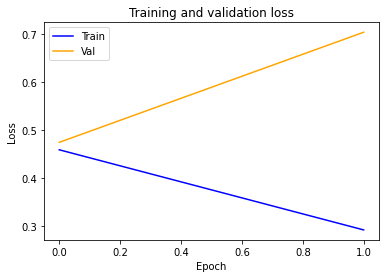

In [47]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['auc']
  val_auc = history.history['val_auc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation AUC')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_auc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [51]:
def heatmap(slide, mask, zoom_level1, zoom_level2, dim, stride, threshold=0.5):
    factor1 = int(slide.level_downsamples[zoom_level1])
    factor2 = int(slide.level_downsamples[zoom_level2])
    # Extract Max width and height
    width_1 = slide.level_dimensions[7][0]
    height_1 = slide.level_dimensions[7][1]
    print("Width: %s, Height: %s" %(width_1,height_1))
    # Calculate How many samples do we need on each direction 
    w_samples = width_1//stride 
    h_samples = height_1//stride
    #keeping zoom level 7 as our reference
    labels = []
    predictions = []
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=7, 
                             width=slide.level_dimensions[7][0], 
                             height=slide.level_dimensions[7][1])
    actual_mask = np.zeros((slide_image.shape[0], slide_image.shape[1]))
    predicted_mask = np.zeros((slide_image.shape[0], slide_image.shape[1]))
    
    print(slide_image.shape)
    # Get Higher Level and patches indexes.
    for j in range(0,slide_image.shape[0], stride):
          for i in range(0,slide_image.shape[1], stride):
            x1 = j*factor1*factor_level
            y1 = i*factor1*factor_level
            slide_img1 = read_slide(slide, x = x1, y = y1, level=zoom_level1, width=dim, height=dim)
            tissue_pixels = list(find_tissue_pixels(slide_img1))
            percent_tissue = len(tissue_pixels) / float(slide_img1.shape[0] * slide_img1.shape[0]) * 100
            slide_img1 = slide_img1/255.
            if percent_tissue > 10: #Only predict when tissue more than 10%
              factor = ((dim-dim//(factor1//factor2))//2)*factor1
              slide_img2 = read_slide(slide, x = (x1+factor), y = (y1+factor), level=zoom_level2, width=dim, height=dim)/255.
              prediction = model.predict((np.expand_dims(slide_img1.astype('float32'),axis=0),np.expand_dims(slide_img2.astype('float32'),axis=0)))
              predictions.append(np.mean(prediction))
              if prediction[0] > threshold:
                  predicted_mask[i:i+stride , j:j+stride] = prediction[0]
              else:
                  predicted_mask[i:i+stride , j:j+stride] = 0
              label_mask = read_slide(mask, x = (x1+((dim-128)//2)*factor1), y = (y1+((dim-128)//2)*factor1), level=zoom_level2, width=128, height=128)[:,:,0]
              if np.count_nonzero(label_mask) > 0:
                labels.append(1)
                actual_mask[i:i+stride , j:j+stride] = 1
              else:
                labels.append(0)
                actual_mask[i:i+stride , j:j+stride] = 0
  
    return slide_image, actual_mask, predicted_mask, predictions, labels

In [62]:
slide_img, actual_mask, predicted_mask, predictions, labels = heatmap(testset_tumor_slide[2], testset_mask_slide[2], zoom_level1=3, zoom_level2=2, dim=299, stride=8, threshold=0.75)

Width: 736, Height: 868
(868, 736, 3)


Text(0.5, 1.0, 'predictions')

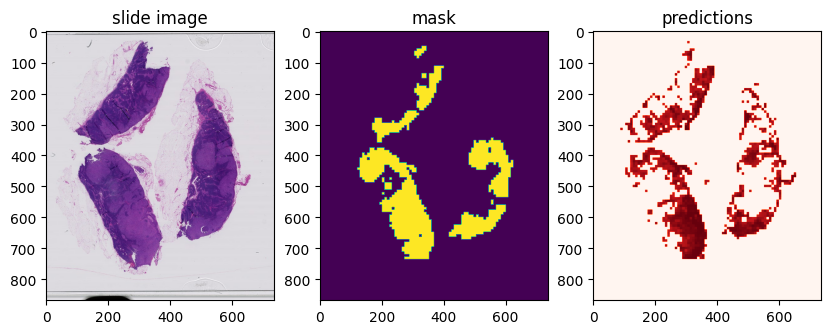

In [63]:
plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 3, 1)
plt.imshow(slide_img)
plt.title("slide image")

plt.subplot(1, 3, 2)
plt.imshow(actual_mask)
plt.title("mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='Reds')
plt.title("predictions")

In [64]:
fpr, tpr, thresholds = metrics.roc_curve(actual_mask.reshape(-1).astype('float32'), 
                                        predicted_mask.reshape(-1), pos_label=None)
print('AUC:%s'%(metrics.auc(fpr, tpr)))

AUC:0.8514725588107291


In [65]:
print(classification_report(actual_mask.reshape(-1).astype('float32'), np.round(predicted_mask.reshape(-1))))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    562560
         1.0       0.70      0.74      0.72     76288

    accuracy                           0.93    638848
   macro avg       0.83      0.85      0.84    638848
weighted avg       0.93      0.93      0.93    638848



In [52]:
slide_img, actual_mask, predicted_mask, predictions, labels = heatmap(testset_tumor_slide[0], testset_mask_slide[0], zoom_level1=3, zoom_level2=2, dim=299, stride=8, threshold=0.75)

Width: 480, Height: 420
(420, 480, 3)


Text(0.5, 1.0, 'predictions')

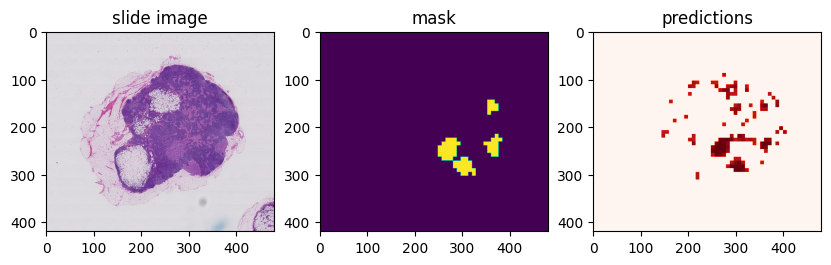

In [53]:
plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 3, 1)
plt.imshow(slide_img)
plt.title("slide image")

plt.subplot(1, 3, 2)
plt.imshow(actual_mask)
plt.title("mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='Reds')
plt.title("predictions")

In [54]:
from sklearn import metrics
import sklearn
from sklearn.metrics import confusion_matrix

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(actual_mask.reshape(-1).astype('float32'), 
                                        predicted_mask.reshape(-1), pos_label=None)
print('AUC:%s'%(metrics.auc(fpr, tpr)))

AUC:0.8393524511799605


In [56]:
from sklearn.metrics import classification_report

In [57]:
print(classification_report(actual_mask.reshape(-1).astype('float32'), np.round(predicted_mask.reshape(-1))))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    197056
         1.0       0.42      0.69      0.52      4544

    accuracy                           0.97    201600
   macro avg       0.71      0.83      0.75    201600
weighted avg       0.98      0.97      0.98    201600



In [58]:
slide_img, actual_mask, predicted_mask, predictions, labels = heatmap(testset_tumor_slide[1], testset_mask_slide[1], zoom_level1=3, zoom_level2=2, dim=299, stride=8, threshold=0.75)

Width: 1024, Height: 560
(560, 1024, 3)


Text(0.5, 1.0, 'predictions')

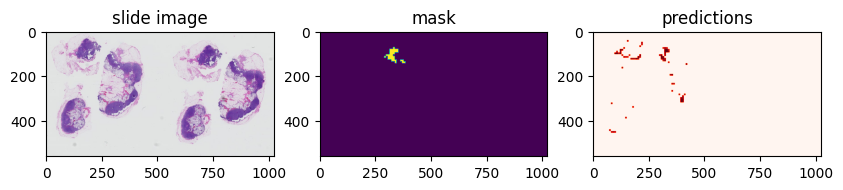

In [59]:
plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 3, 1)
plt.imshow(slide_img)
plt.title("slide image")

plt.subplot(1, 3, 2)
plt.imshow(actual_mask)
plt.title("mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='Reds')
plt.title("predictions")

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(actual_mask.reshape(-1).astype('float32'), 
                                        predicted_mask.reshape(-1), pos_label=None)
print('AUC:%s'%(metrics.auc(fpr, tpr)))

AUC:0.7547098839535814


In [61]:
print(classification_report(actual_mask.reshape(-1).astype('float32'), np.round(predicted_mask.reshape(-1))))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    571200
         1.0       0.26      0.51      0.34      2240

    accuracy                           0.99    573440
   macro avg       0.63      0.75      0.67    573440
weighted avg       1.00      0.99      0.99    573440

